# PIV analysis in droplets

The key is to apply a mask. Sometimes the mask is dynamic.

In [33]:
from openpiv import tools, pyprocess, validation, filters, scaling

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage import io
import os
from scipy.signal import medfilt2d

In [6]:
frame_a = io.imread(os.path.join('test_images', '03125.tif'))
frame_b = io.imread(os.path.join('test_images', '03126.tif'))

In [23]:
winsize = 20 # pixels, interrogation window size in frame A
searchsize = 30  # pixels, search area size in frame B
overlap = 10 # pixels, 50% overlap
dt = 0.02 # sec, time interval between the two frames

u0, v0, sig2noise = pyprocess.extended_search_area_piv(
    frame_a.astype(np.int32),
    frame_b.astype(np.int32),
    window_size=winsize,
    overlap=overlap,
    dt=dt,
    search_area_size=searchsize,
    sig2noise_method='peak2peak',
)

In [24]:
x, y = pyprocess.get_coordinates(
    image_size=frame_a.shape,
    search_area_size=searchsize,
    overlap=overlap,
    window_size=winsize
)

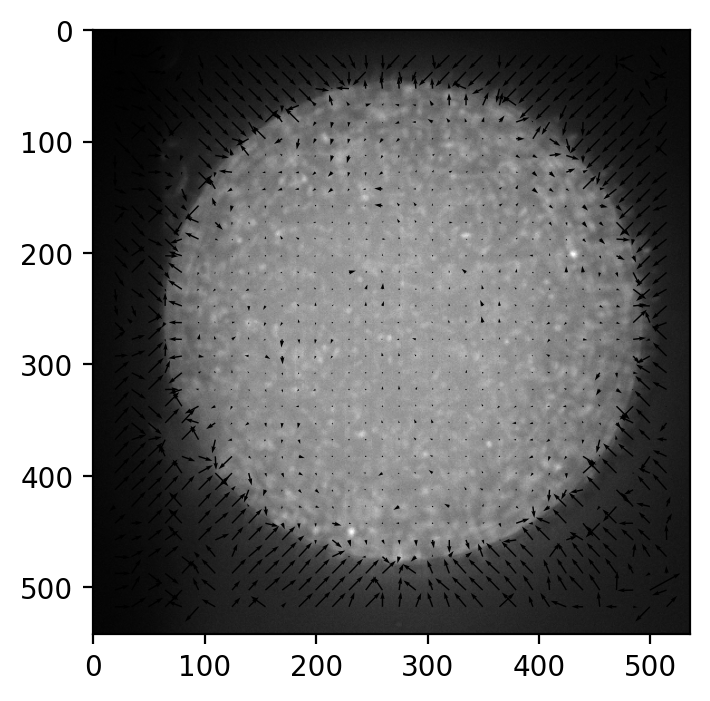

In [11]:
plt.figure(dpi=200)
plt.imshow(frame_a, cmap='gray')
plt.quiver(x, y, u0, v0)

In [25]:
# apply mask
# frame ImageJ, we obtain the position and size of the droplet: x0, y0 and d
# x0, y0 are the upper left corner coords
# d is the diameter of the droplet
x0 = 59
y0 = 43
d = 438

In [26]:
# translate the representation into center-radius representation
r = d / 2
xc = x0 + r
yc = y0 + r

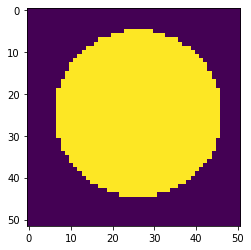

In [35]:
m = (x-xc) ** 2 + (y-yc) ** 2 < (r-winsize) ** 2
plt.imshow(m)

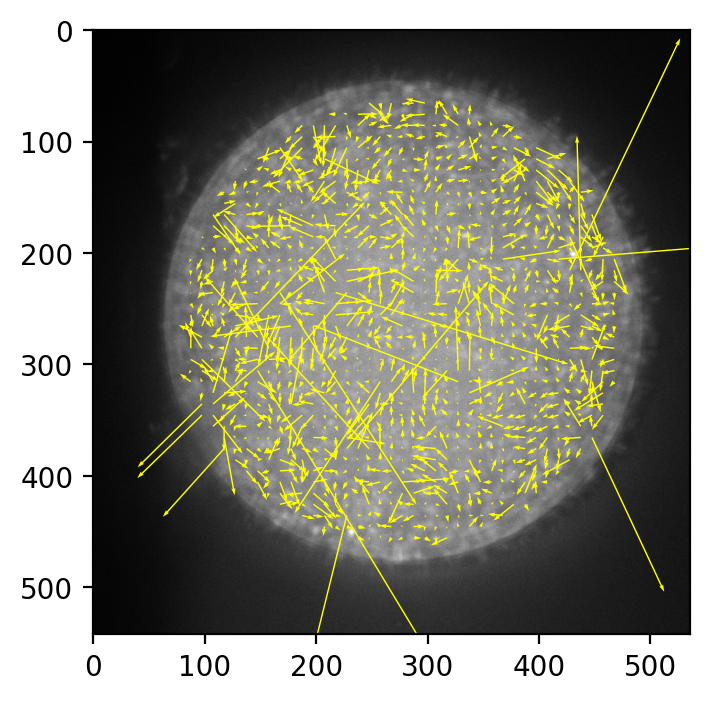

In [40]:
plt.figure(dpi=200)
plt.imshow(frame_a, cmap='gray')
um = u0 * m
vm = v0 * m
xm = x * m
ym = y * m
plt.quiver(xm, ym, um, vm, color='yellow')

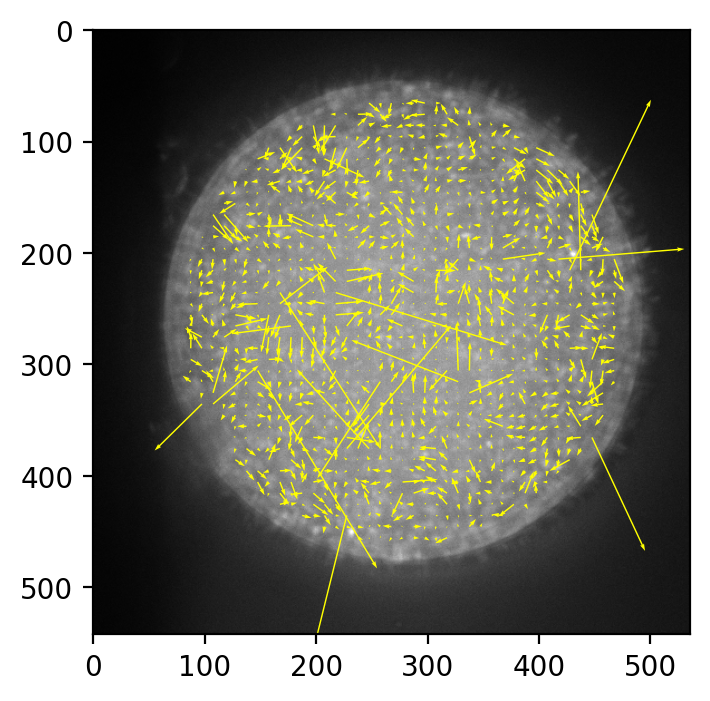

In [41]:
u1, v1, mask = validation.sig2noise_val(
    um, vm,
    sig2noise,
    threshold = 1.05,
)

plt.figure(dpi=200)
plt.imshow(frame_a, cmap='gray')
plt.quiver(xm, ym, u1, v1, color='yellow')

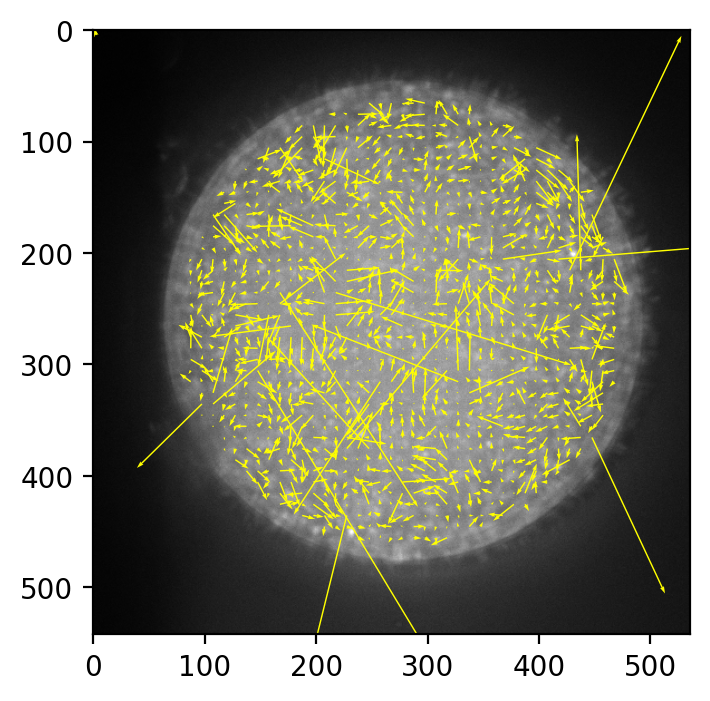

In [42]:
u2, v2 = filters.replace_outliers(
    u1, v1,
    method='localmean',
    max_iter=3,
    kernel_size=3,
)

plt.figure(dpi=200)
plt.imshow(frame_a, cmap='gray')
plt.quiver(xm, ym, u2, v2, color='yellow')

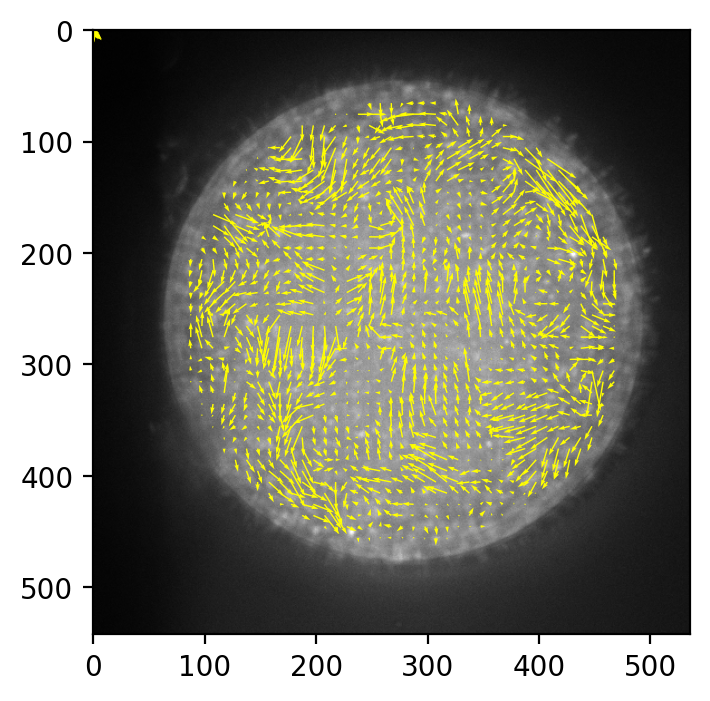

In [43]:
u3 = medfilt2d(u2, 3)
v3 = medfilt2d(v2, 3)

plt.figure(dpi=200)
plt.imshow(frame_a, cmap='gray')
plt.quiver(xm, ym, u3, v3, color='yellow')

Text(0, 0.5, 'v (px/frame)')

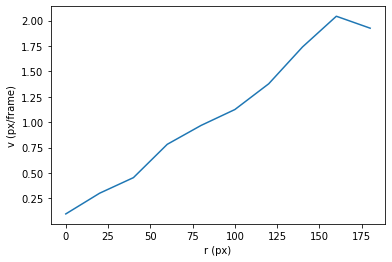

In [53]:
# azimuthal velocity profile (0:r-w:dr)
dr = winsize
r_list = []
v_list = []
for i in np.arange(0, r-winsize, dr):
    r2 = (xm - xc) ** 2 + (ym - yc) ** 2
    mask = (r2 > i**2) & (r2 < (i + dr) ** 2)
    mean_v = (((u3 * mask) ** 2 + (v3 * mask) ** 2) ** 0.5).mean()
    r_list.append(i)
    v_list.append(mean_v)
plt.plot(r_list, v_list)
plt.xlabel('r (px)')
plt.ylabel('v (px/frame)')

In [ ]:
# pix/frame -> 0.16um/0.02s

## Bright field image test

In [54]:
frame_a = io.imread(os.path.join('test_images', 'bf_images', '06972.tif'))
frame_b = io.imread(os.path.join('test_images', 'bf_images', '06973.tif'))

In [57]:
# apply ROI
x0, y0 = 132, 8
w, h = 691, 805
xc, yc = 416, 417
r = 790 / 2

In [62]:
frame_a_crop = frame_a[y0:y0+h, x0:x0+w]
frame_b_crop = frame_b[y0:y0+h, x0:x0+w]

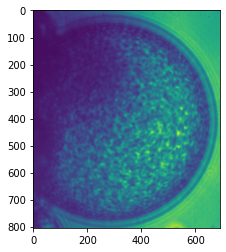

In [61]:
plt.imshow(frame_a_crop)

In [75]:
winsize = 40 # pixels, interrogation window size in frame A
searchsize = 40  # pixels, search area size in frame B
overlap = 20 # pixels, 50% overlap
dt = 0.02 # sec, time interval between the two frames

u0, v0, sig2noise = pyprocess.extended_search_area_piv(
    frame_a_crop.astype(np.int32),
    frame_b_crop.astype(np.int32),
    window_size=winsize,
    overlap=overlap,
    dt=dt,
    search_area_size=searchsize,
    sig2noise_method='peak2peak',
)

In [76]:
x, y = pyprocess.get_coordinates(
    image_size=frame_a_crop.shape,
    search_area_size=searchsize,
    overlap=overlap,
    window_size=winsize
)

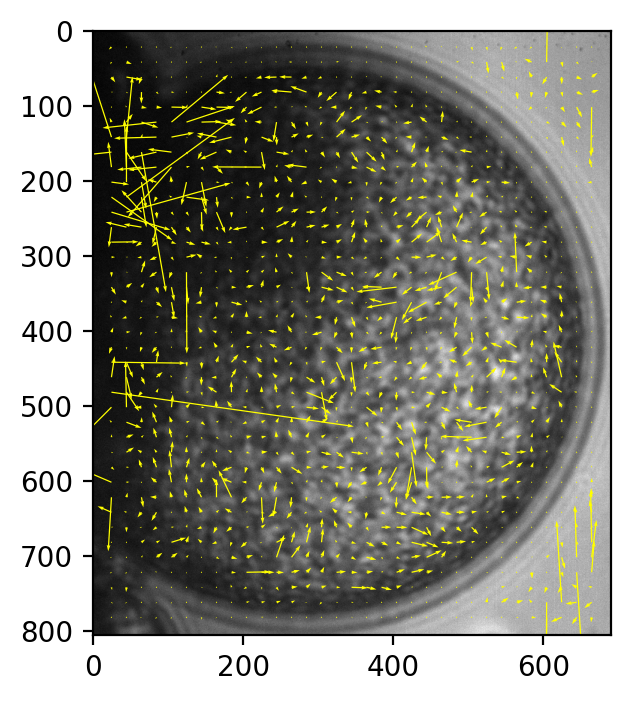

In [77]:
plt.figure(dpi=200)
plt.imshow(frame_a_crop, cmap='gray')
plt.quiver(x, y, u0, v0, color='yellow')

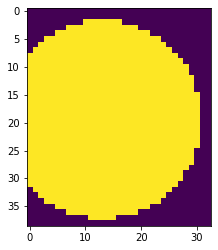

In [78]:
# generate mask
xcr, ycr = xc-x0, yc-y0
mask = (x-xcr) ** 2 + (y-ycr) ** 2 < (r-winsize) ** 2
plt.imshow(mask)

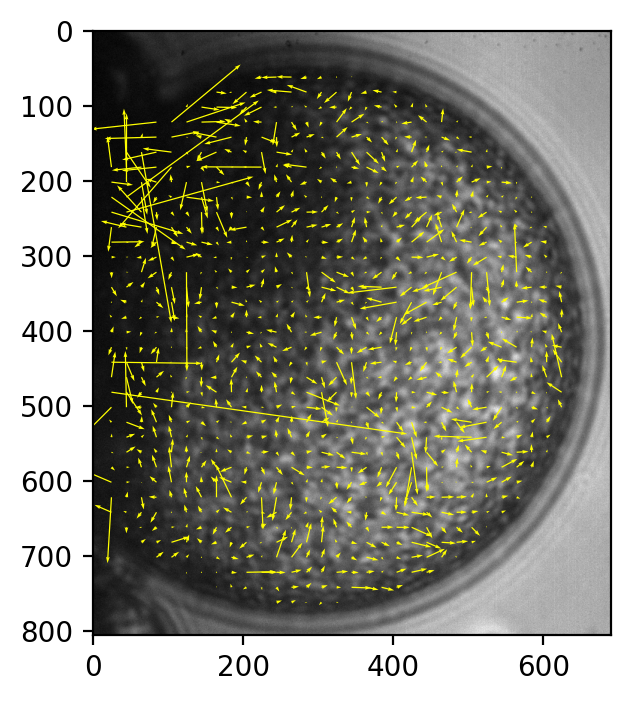

In [79]:
plt.figure(dpi=200)
plt.imshow(frame_a_crop, cmap='gray')
um = u0 * mask
vm = v0 * mask
xm = x * mask
ym = y * mask
plt.quiver(xm, ym, um, vm, color='yellow')

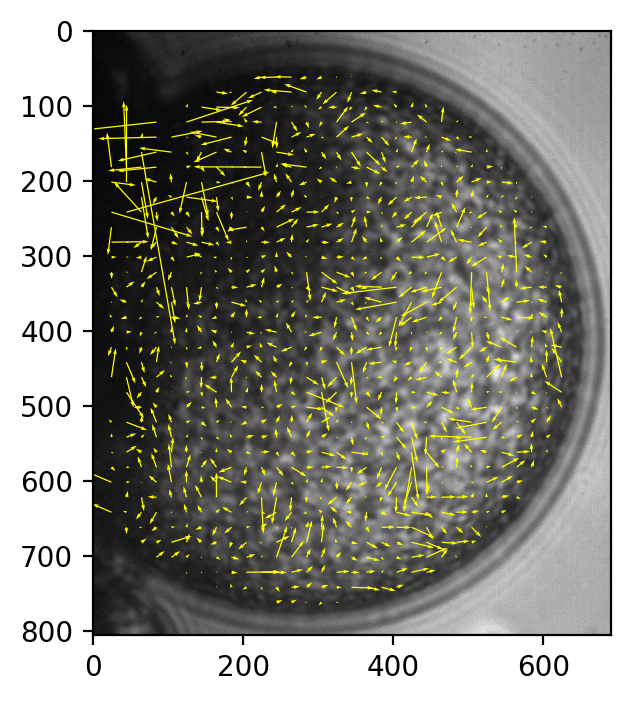

In [80]:
u1, v1, mask = validation.sig2noise_val(
    um, vm,
    sig2noise,
    threshold = 1.05,
)

plt.figure(dpi=200)
plt.imshow(frame_a_crop, cmap='gray')
plt.quiver(xm, ym, u1, v1, color='yellow')

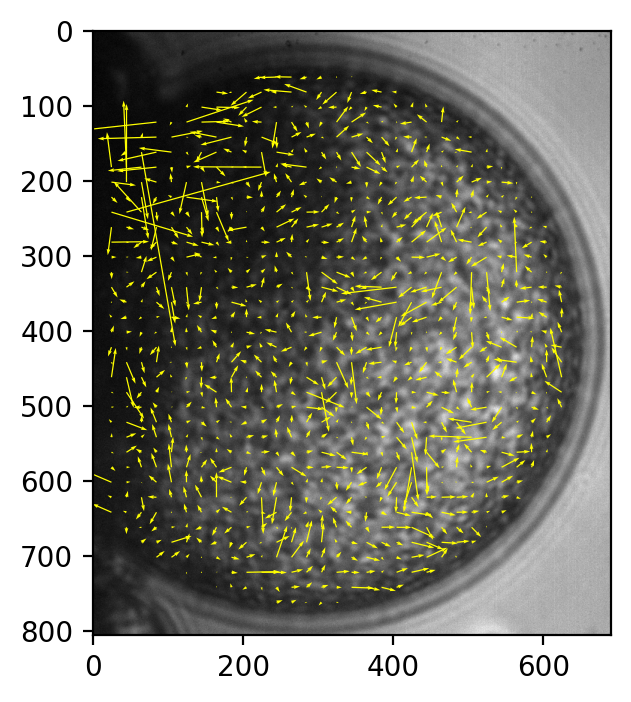

In [81]:
u2, v2 = filters.replace_outliers(
    u1, v1,
    method='localmean',
    max_iter=3,
    kernel_size=3,
)

plt.figure(dpi=200)
plt.imshow(frame_a_crop, cmap='gray')
plt.quiver(xm, ym, u2, v2, color='yellow')

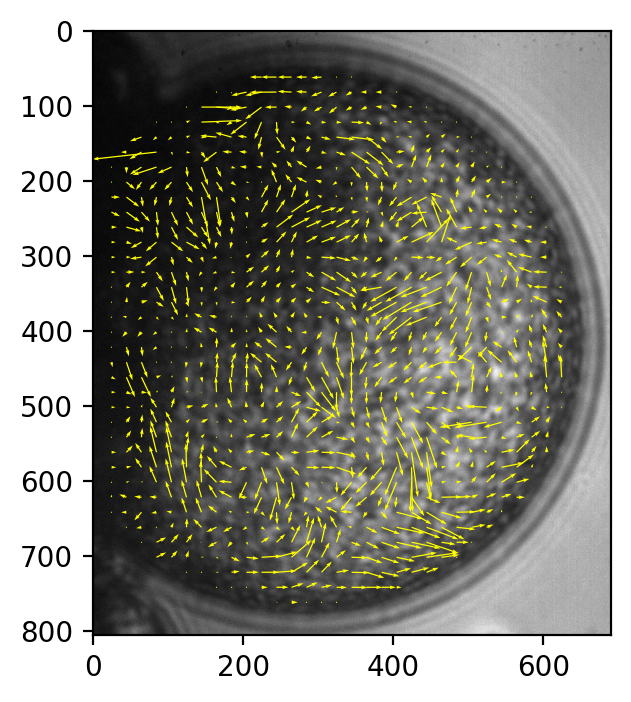

In [83]:
u3 = medfilt2d(u2, 3)
v3 = medfilt2d(v2, 3)

plt.figure(dpi=200)
plt.imshow(frame_a_crop, cmap='gray')
plt.quiver(xm, ym, u3, v3, color='yellow')

Text(0, 0.5, 'v (px/frame)')

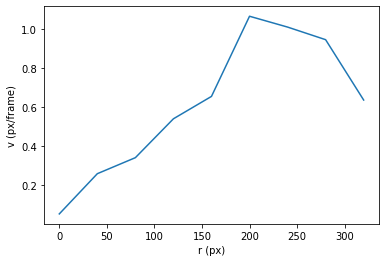

In [91]:
# azimuthal velocity profile (0:r-w:dr)
dr = winsize
r_list = []
v_list = []
for i in np.arange(0, r-winsize, dr):
    r2 = (xm - xcr) ** 2 + (ym - ycr) ** 2
    mask = (r2 > i**2) & (r2 < (i + dr) ** 2)
    mean_v = (((u3 * mask) ** 2 + (v3 * mask) ** 2) ** 0.5).mean()
    r_list.append(i)
    v_list.append(mean_v)
plt.plot(r_list, v_list)
plt.xlabel('r (px)')
plt.ylabel('v (px/frame)')